In [2]:
import sqlite3
import pandas as pd
import numpy as np
import os
from scipy.spatial.distance import cdist
import seaborn as sns
import mpltern
import matplotlib as mpl
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from matplotlib.cm import plasma_r
import matplotlib.pyplot as plt
rc_fonts = {
    "text.usetex": True,
    "font.size": 20,
    'axes.titlesize': 17,
    "axes.labelsize": 25,
    "legend.fontsize": 10,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    'figure.titlesize': 20,
    'mathtext.default': 'regular',
    'text.latex.preamble': r"\usepackage{bm}",
}
mpl.rcParams.update(rc_fonts)
connection = sqlite3.connect(os.path.join(os.path.dirname(os.path.abspath('__file__')), 'sa_results.db'))

In [11]:
from datetime import datetime
print(datetime.now())

2023-07-17 13:51:12.657367


In [3]:
df = pd.read_sql_query("SELECT * FROM single_unfusion_results", connection).iloc[1:]
parameter_columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']
for col in parameter_columns: df[col] = pd.to_numeric(df[col], errors='coerce')
df.loc[df['energy'] > 1, 'energy'] = df['energy'].apply(lambda x: x / 20 if x > 1 else x)
df = df.sort_values(by='energy', ascending=False)
df.describe()

,id,p1,p2,p3,p4,p5,p6,p7,p8,p9,temp,energy,optimise_ratios
count,2174.000000,6078.000000,6078.000000,6078.000000,6078.000000,6078.000000,6078.000000,6078.000000,6078.000000,6078.000000,6078.000000,6078.000000,6078.000000
mean,7364.016559,0.353116,0.389834,0.257050,-0.523593,-0.421097,-0.188649,-0.256375,-0.279676,0.529288,221.112758,0.912862,0.605133
std,6645.644374,0.180300,0.209613,0.172654,0.630090,0.469407,0.345221,0.296920,0.976662,0.497721,289.223906,0.005217,0.488862
min,2.000000,0.000000,0.000000,0.000000,-1.560000,-1.420000,-1.350000,-1.060000,-3.010000,-1.310000,0.390581,0.905050,0.000000
25%,545.250000,0.240000,0.230000,0.160000,-1.040000,-0.850000,-0.290000,-0.540000,-0.290000,0.320000,4.352133,0.908647,0.000000
50%,13280.500000,0.370000,0.400000,0.230000,-0.670000,-0.320000,-0.100000,-0.280000,0.050000,0.700000,48.494525,0.911074,1.000000
75%,13823.750000,0.440000,0.480000,0.330000,0.000000,-0.100000,0.040000,0.000000,0.280000,0.820000,413.409349,0.915905,1.000000
max,14368.000000,1.000000,1.000000,1.000000,1.290000,0.910000,0.740000,0.720000,1.330000,1.530000,1000.000000,0.931493,1.000000


In [4]:
min_energy = df[df['energy'] == df['energy'].min()][['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']]
print(df['energy'].min())
higher_energy = df[df['energy'] > df['energy'].min()][['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']]
min_dists = cdist(min_energy, higher_energy).min(axis=1)
min_energy['min_dist'] = min_dists
max_min_dist_row = min_energy[min_energy['min_dist'] == min_energy['min_dist'].max()]
print(max_min_dist_row[['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']])

0.9050501025798026
        p1   p2    p3    p4    p5   p6    p7    p8    p9
5956  0.37  0.4  0.23 -0.94 -0.71  0.5 -0.45  0.47  0.59


In [13]:
class LogBaseNorm(Normalize):
    def __init__(self, vmin=None, vmax=None, log_base=10, clip=False):
        self.log_base = log_base
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        log_base = self.log_base
        vmin, vmax = self.vmin, self.vmax
        if vmin > vmax:
            raise ValueError("minvalue must be less than or equal to maxvalue")
        elif vmin <= 0:
            raise ValueError("minvalue must be positive")
        with np.errstate(divide='ignore'): 
            result = np.ma.masked_array(np.log(value / vmin) / np.log(vmax / vmin) / np.log(log_base))
        return result

norm = LogBaseNorm(vmin=0.905, vmax=0.935, log_base=1.3)
cmap = plasma_r

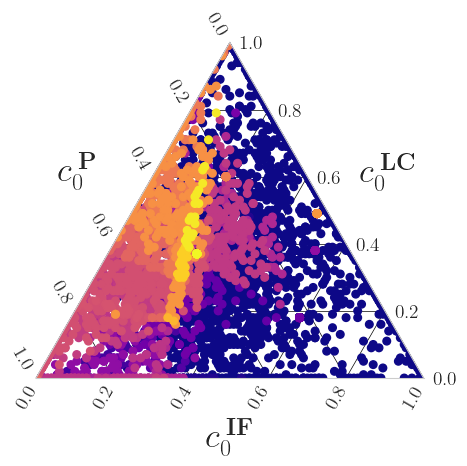

In [14]:
data = df[['p1','p2','p3','energy']]
fig, tax = plt.subplots(subplot_kw={'projection': 'ternary'}, figsize=(5, 5))
tax.set_tlabel(r'$c_0^{\;\bf{LC}}$')
tax.set_llabel(r'$c_0^{\;\bf{P}}$')
tax.set_rlabel(r'$c_0^{\;\bf{IF}}$')
tax.taxis.set_label_position('tick1')
tax.laxis.set_label_position('tick1')
tax.raxis.set_label_position('tick1')
tax.taxis.set_label_rotation_mode('horizontal')
tax.laxis.set_label_rotation_mode('horizontal')
tax.raxis.set_label_rotation_mode('horizontal')
costs = data['energy']
sc = tax.scatter(data['p1'], data['p2'], data['p3'], c=costs, cmap=cmap, s=30, norm=norm, zorder=1)
# cbar = plt.colorbar(sc, location='right', shrink=0.6, pad = 0.1, ticks=np.arange(0.895, 0.935, 0.005))
# cbar.ax.set_title(r'$\textit{Energy}$', loc='left', pad=18)
# cbar.ax.tick_params(labelsize=14)
tax.grid(linestyle='-', linewidth=0.5, color='black', alpha=1, zorder=3)
plt.show()

In [15]:
# fig.savefig('ternary_plot', bbox_inches='tight')

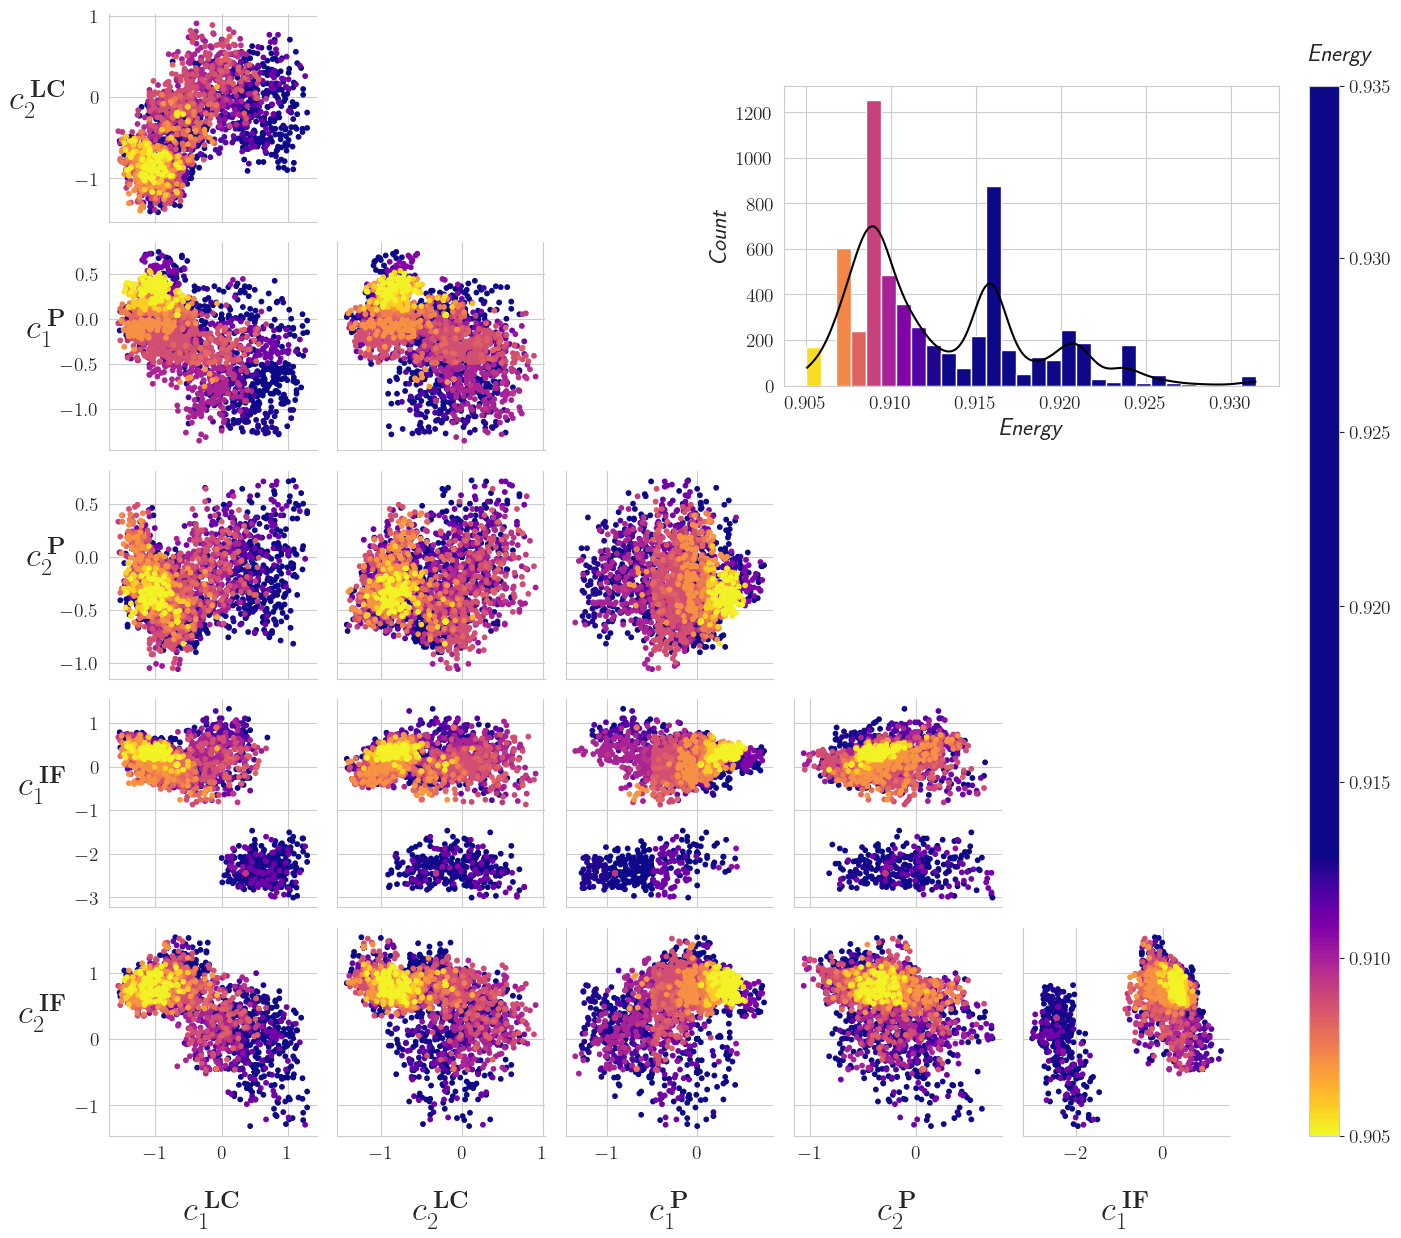

In [16]:
columns_to_plot = ['p4', 'p5', 'p6', 'p7', 'p8', 'p9']
def plot_with_colorbar(x, y, c, **kwargs):
    ax = plt.gca()
    kwargs.pop('color', None)
    points = ax.scatter(x, y, c=c, cmap=cmap, norm=norm, s=10, **kwargs)
    return points

sns.set_style("whitegrid")
g = sns.PairGrid(df[columns_to_plot], corner=True)
g.map_lower(plot_with_colorbar, c=df['energy'])

labels = [r'$c_1^{\;\bf{LC}}$',r'$c_2^{\;\bf{LC}}$',r'$c_1^{\;\bf{P}}$',r'$c_2^{\;\bf{P}}$',r'$c_1^{\;\bf{IF}}$',r'$c_2^{\;\bf{IF}}$']
for i, label in enumerate(labels):
    if g.axes[5, i]: g.axes[5, i].set_xlabel(label, labelpad = 20)
    if g.axes[i, 0]: g.axes[i, 0].set_ylabel(label)

for i, ax in enumerate(g.axes.flat):
    if i % 7 == 0:
        ax.set_visible(False)
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)

for ax in g.axes.flatten():
    if ax:
        ax.set_ylabel(ax.get_ylabel(), rotation = 0)
        ax.get_yaxis().set_label_coords(-0.2,0.5)
        ax.yaxis.get_label().set_horizontalalignment('right')
    
cbar_ax = g.fig.add_axes([0.85, 0.05, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
g.fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_title(r'$\textit{Energy}$', loc='left', pad=18)

energy_ax = g.fig.add_axes([0.5, 0.55, 0.33, 0.2])
bins = sns.histplot(df['energy'], bins=30, kde=True, ax=energy_ax)
for bar in bins.containers[1]:
    energy_val = (bar.get_x() + bar.get_width()/2)
    color = cmap(norm(energy_val))
    bar.set_facecolor(color)
line = bins.get_lines()[0]
x = line.get_xdata()
y = line.get_ydata()
segments = [np.column_stack((x, y))]
lc = LineCollection(segments, color='black')
energy_ax.add_collection(lc)
line.remove()
energy_ax.set_xlabel(r'\textit{Energy}', fontsize = 17)
energy_ax.set_ylabel(r'\textit{Count}', fontsize = 17)

plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
plt.show()

In [17]:
# g.fig.savefig('energy_plot.pdf', dpi=300, bbox_inches='tight')

In [18]:
# fig.savefig('ternary2.pdf', dpi=300, bbox_inches='tight')